# Práctico — Algoritmos de búsqueda local

Este práctico se enmarca en los capítulos de **búsqueda local** del libro *Inteligencia Artificial: Un Enfoque Moderno* (Russell & Norvig). El objetivo es **explorar y comparar** distintos **métodos de búsqueda local** (p. ej., *hill climbing*, *simulated annealing*, *local beam search*) y **medir su desempeño** bajo diferentes configuraciones y heurísticas.



## Objetivo del práctico
- Comprender la **dinámica** de los algoritmos de búsqueda local y sus **trade-offs** (exploración vs. explotación, robustez vs. costo).
- Implementar y ejecutar **experimentos repetibles**, recolectando métricas (tiempo, tasa de éxito, costo/heurística).
- Analizar cómo influyen los **hiperparámetros** y las **heurísticas** en los resultados.

## El problema: NPuzzle
El **NPuzzle** (generalización del clásico **8-Puzzle**) consiste en un tablero cuadrado de tamaño n con fichas numeradas y un **hueco** (representado con 0). En cada movimiento se desliza una ficha adyacente al hueco hacia su posición, intercambiándola con el 0.  
La meta estándar es alcanzar la **configuración objetivo** (fichas en orden y hueco en su posición objetivo).

**¿Por qué es útil para búsqueda local?**
- Espacio de estados moderado pero suficiente para observar diferencias entre algoritmos.
- **Operadores** simples (mover el hueco ↑ ↓ ← →).
- **Heurísticas** naturales y comparables.

> Convención experimental: índice **zero-based** y, salvo mención explícita, **excluimos el hueco (0)** del cómputo de las heurísticas (p. ej., Manhattan/Euclidiana).

## Métodos base y heurísticas para los experimentos

**Estado y operadores**
- `NPuzzleState(size, tiles)`: representación del tablero.
- `get_successors()`: genera estados alcanzables en un movimiento.
- `is_goal()`: verifica si el tablero está en la configuración objetivo.
-  `misplaced()`: cuenta de fichas fuera de lugar como métrica simple.

**Algoritmos de búsqueda local**
- **Hill Climbing** (ascenso de colinas) sin reinicios aleatorios. 
- **Simulated Annealing** (temple simulado) con enfriamiento geométrico.
- **Local Beam Search** (búsqueda por haz) con tamaño de haz k y selección de mejores sucesores.

**Heurísticas (funciones de costo a minimizar)**
- **Distancia de Manhattan**:  
- **Distancia Euclidiana**: 
- (Baseline) **Misplaced tiles**: número de fichas fuera de lugar.

## Inicialización de componentes y utils.

In [4]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output


##Constantes 
PUZZLE_SIZE = 3
N_MOVES=33

class NPuzzleState:
    def __init__(self, size=3, tiles=None):
        self.size = size
        if tiles is None:
            self.tiles = np.arange(size*size).reshape(size, size)
        else:
            self.tiles = np.array(tiles)

        self.blank_pos = np.where(self.tiles == 0)

    def __eq__(self, other):
        return np.array_equal(self.tiles, other.tiles)

    def __hash__(self):
        return hash(self.tiles.tobytes())

    def get_successors(self):
        """
        Generar todos los estados sucesores válidos
        """
        moves = []
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        current_r, current_c = self.blank_pos[0][0], self.blank_pos[1][0]

        for dr, dc in directions:
            new_r, new_c = current_r + dr, current_c + dc


            if 0 <= new_r < self.size and 0 <= new_c < self.size:

                new_tiles = self.tiles.copy()
                new_tiles[current_r, current_c], new_tiles[new_r, new_c] = new_tiles[new_r, new_c], new_tiles[current_r, current_c]
                moves.append(NPuzzleState(self.size, new_tiles))

        return moves

    def misplaced(self) -> int:
        """
        Cuenta cuántas casillas están fuera de su posición objetivo,
        INCLUYENDO el hueco (0).
        Objetivo asumido (coherente con NPuzzleState.is_goal):
        0..n^2-1 en orden fila-major y 0 en (0,0).
        """
        n = self.size
        cnt = 0
        for r in range(n):
            for c in range(n):
                v = self.tiles[r, c]
                gr, gc = divmod(int(v), n)  # objetivo cero-based (incluye al 0 -> (0,0))
                if r != gr or c != gc:
                    cnt += 1
        return cnt

    def is_goal(self):
        """Verificar si es el estado meta"""
        goal = np.arange(self.size*self.size).reshape(self.size, self.size)
        return np.array_equal(self.tiles, goal)

    def __str__(self):
        return str(self.tiles)


In [5]:

def shuffle_puzzle(state, moves=40):
    """
    Mezclar el puzzle haciendo movimientos aleatorios
    """
    current = state
    for i in range(moves):
        successors = current.get_successors()
        if not successors:
            break
        current = random.choice(successors)
    return current

def visualize_puzzle(state, title="Estado del Puzzle"):
    """
    Visualizar el estado del puzzle usando matplotlib
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(state.tiles, cmap='viridis')

    for i in range(state.size):
        for j in range(state.size):
            if state.tiles[i, j] != 0:
                ax.text(j, i, str(state.tiles[i, j]), va='center', ha='center', fontsize=20,
                       color='white', weight='bold')

    plt.title(title)
    plt.axis('off')
    plt.show()


### Heurísticas

In [6]:
from functools import lru_cache
import math
import numpy as np

# ---Heursiticas---
def manhattan_distance(puzzle) -> int:
    tt = tuple(int(x) for x in np.asarray(puzzle.tiles).ravel())
    return manhattan_inner_3x3(tt)
def euclidean_distance(puzzle) -> float:
    tt = tuple(int(x) for x in np.asarray(puzzle.tiles).ravel())
    return euclidean_inner_3x3(tt)


# ----- Funciones internas -----
@lru_cache(maxsize=None)
def manhattan_inner_3x3(tiles_tuple: tuple) -> int:
    total = 0
    for idx, v in enumerate(tiles_tuple):
        if v == 0: continue
        r, c = divmod(idx, 3)
        gr, gc = divmod(v, 3)
        total += abs(r - gr) + abs(c - gc)
    return total

@lru_cache(maxsize=None)
def euclidean_inner_3x3(tiles_tuple: tuple) -> float:
    total = 0.0
    for idx, v in enumerate(tiles_tuple):
        if v == 0: continue
        r, c = divmod(idx, 3)
        gr, gc = divmod(v, 3)
        dr, dc = r - gr, c - gc
        total += math.hypot(dr, dc)
    return total



Estado objetivo:


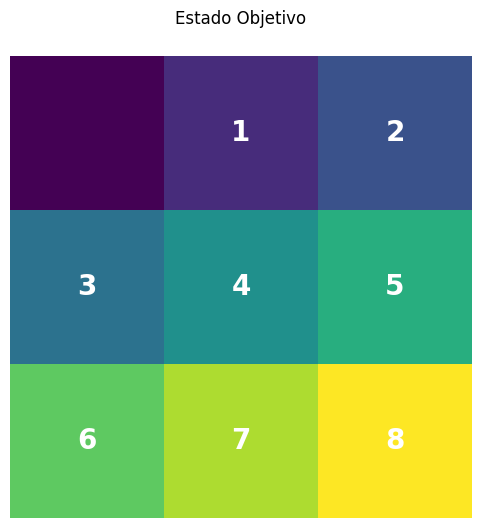

Diferencia entre casilleros: 0
Estado inicial mezclado:
Diferencia entre casilleros: 8


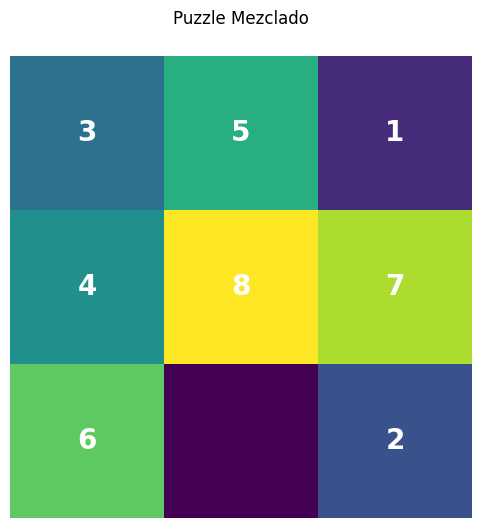

In [7]:
print("Estado objetivo:")

goal_state = NPuzzleState(PUZZLE_SIZE)
visualize_puzzle(goal_state, "Estado Objetivo")
print("Diferencia entre casilleros:", goal_state.misplaced())


initial = shuffle_puzzle(goal_state, N_MOVES)

print("Estado inicial mezclado:")
print("Diferencia entre casilleros:", initial.misplaced())
visualize_puzzle(initial, "Puzzle Mezclado")

## Ejercicio 1 - Ascensión de colinas
Completa el codigo faltante para ejecutar el algoritmo de Hill Climbing.


In [8]:
# Mejora de las métricas de ejecución:
from dataclasses import dataclass
@dataclass
class RunStats:
    success: bool
    steps: int
    expanded: int
    time_sec: float
    best_cost: float
    final_state: NPuzzleState

# =========================
# 1) Hill Climbing (steepest-ascent)
#    Referencia Bibliográfica: R&N, p. 126
# =========================

def hill_climbing(start: NPuzzleState, h_func=manhattan_distance, max_steps=10_000) -> RunStats:
    t0 = time.time()
    current = start
    current_cost = h_func(current)
    expanded = 0
    steps = 0

    while steps < max_steps and not current.is_goal():
        neighbors = current.get_successors()
        expanded += 1
        # Vecino de menor costo (mejor descenso)
        best = current
        best_cost = current_cost
        for nb in neighbors:
            c = h_func(nb)
            if c < best_cost:
                best = nb
                best_cost = c
        if best_cost < current_cost:   # mejora estricta
            current = best
            current_cost = best_cost
            steps += 1
        else:
            # Atascados
            break

    return RunStats(
        success=current.is_goal(),
        steps=steps,
        expanded=expanded,
        time_sec=time.time() - t0,
        best_cost=current_cost,
        final_state=current
    )


EJECUTANDO HILL CLIMBING
Diferencia entre casilleros: 3
¿Es estado meta? False
Tiempo de ejecución: 0.0009906291961669922 segundos


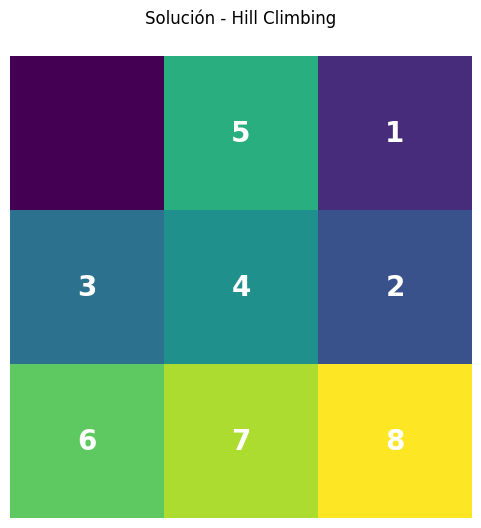

In [9]:
print("\n" + "="*50)
print("EJECUTANDO HILL CLIMBING")
print("="*50)

start_time = time.time()
solution_hc = hill_climbing(initial, manhattan_distance, 100_000)
hc_time = time.time() - start_time

print("Diferencia entre casilleros:", solution_hc.final_state.misplaced())
print("¿Es estado meta?", solution_hc.final_state.is_goal())
print("Tiempo de ejecución:", hc_time, "segundos")
visualize_puzzle(solution_hc.final_state, "Solución - Hill Climbing")

## Ejercicio 2 - Temple simulado
Completa el codigo faltante para ejecutar el algoritmo de Simulated Annealing


In [10]:
# =========================
# 2) Simulated Annealing
#    Referencias del libro: R&N, p. 129 (enfriamiento geométrico)
# =========================
def simulated_annealing(
    start: NPuzzleState,
    h_func=manhattan_distance,
    T0=10.0,
    alpha=0.995,           # factor geométrico
    Tmin=1e-3,
    max_iters=200_000
) -> RunStats:
    """#TO DO: Temple simulado con aceptación por prob. e^{-Δ/T} para Δ>0."""
    t0 = time.time()
    current = start
    current_cost = h_func(current)
    expanded = 0
    steps = 0
    T = T0

    for it in range(max_iters):
        if current.is_goal() or T < Tmin:
            break
        neighbors = current.get_successors()
        expanded += 1
        next_state = random.choice(neighbors)
        next_cost = h_func(next_state)
        delta = next_cost - current_cost
        if delta <= 0:
            # Aceptamos mejoras/no-empeora
            current, current_cost = next_state, next_cost
        else:
            # Aceptamos con prob e^{-delta/T}
            if random.random() < math.exp(-delta / T):
                current, current_cost = next_state, next_cost
        steps += 1
        T *= alpha

    return RunStats(
        success=current.is_goal(),
        steps=steps,
        expanded=expanded,
        time_sec=time.time() - t0,
        best_cost=current_cost,
        final_state=current
    )


EJECUTANDO SIMULATED ANNEALING
Diferencia entre casilleros: 0
¿Es estado meta? True
Tiempo de ejecución: 0.259385347366333 segundos


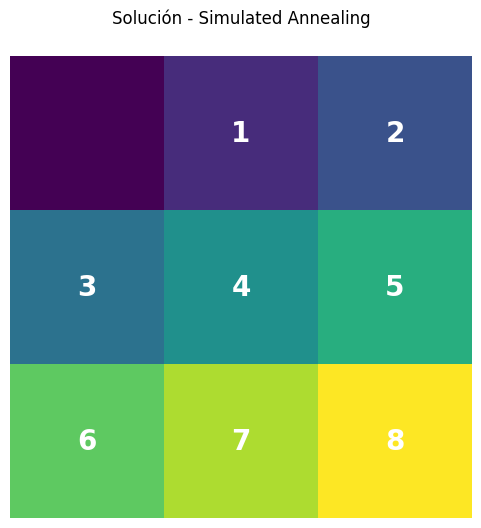

In [11]:
print("\n" + "="*50)
print("EJECUTANDO SIMULATED ANNEALING")
print("="*50)

start_time = time.time()
solution_sa = simulated_annealing(initial, manhattan_distance, T0=30, alpha=0.9997, Tmin=1e-3, max_iters=400_000)
sa_time = time.time() - start_time

print("Diferencia entre casilleros:", solution_sa.final_state.misplaced())
print("¿Es estado meta?", solution_sa.final_state.is_goal())
print("Tiempo de ejecución:", sa_time, "segundos")
visualize_puzzle(solution_sa.final_state, "Solución - Simulated Annealing")


## Ejercicio 3 - Busqueda por Haz Local

Completa el codigo faltante del algoritmo basandote en https://www.cs.umd.edu/~nau/cmsc421/chapter04b.pdf y la bibliografia recomendada.  

In [12]:
# =========================
# 3) Local Beam Search (determinístico)
#    R&N, p. 131
# =========================
def local_beam(
    start: NPuzzleState,
    h_func=manhattan_distance,
    k=5,
    max_iters=50_000
) -> RunStats:
    """#TO DO: Búsqueda por haz local determinística (mantener los k mejores)."""
    t0 = time.time()
    frontier = [start]
    expanded = 0
    steps = 0

    if start.is_goal():
        return RunStats(True, 0, 0, time.time()-t0, 0, start)

    while steps < max_iters:
        # Sucesores de todo el haz
        all_successors = []
        for s in frontier:
            if s.is_goal():
                # cortar
                return RunStats(True, steps, expanded, time.time()-t0, 0, s)
            succ = s.get_successors()
            expanded += 1
            all_successors.extend(succ)

        # k con menor h
        all_successors.sort(key=h_func)
        new_frontier = all_successors[:k]

        # Si no hay mejora (mismo conjunto de configuraciones), parar
        old_set = {tuple(x.tiles.flatten()) for x in frontier}
        new_set = {tuple(x.tiles.flatten()) for x in new_frontier}
        if new_set == old_set:
            best = min(frontier, key=h_func)
            return RunStats(best.is_goal(), steps, expanded, time.time()-t0, h_func(best), best)

        frontier = new_frontier
        steps += 1

    best = min(frontier, key=h_func)
    return RunStats(best.is_goal(), steps, expanded, time.time()-t0, h_func(best), best)


EJECUTANDO LOCAL BEAM
Diferencia entre casilleros: 0
¿Es estado meta? True
Tiempo de ejecución: 0.004274845123291016 segundos


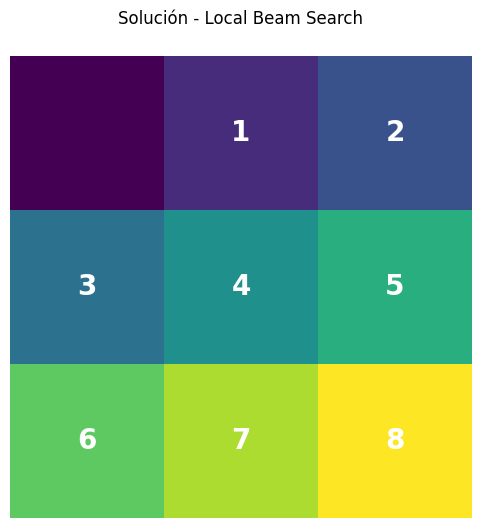

In [13]:
print("\n" + "="*50)
print("EJECUTANDO LOCAL BEAM")
print("="*50)

start_time = time.time()
solution_sa = local_beam(initial, manhattan_distance, k=8, max_iters=400_000)
sa_time = time.time() - start_time

print("Diferencia entre casilleros:", solution_sa.final_state.misplaced())
print("¿Es estado meta?", solution_sa.final_state.is_goal())
print("Tiempo de ejecución:", sa_time, "segundos")
visualize_puzzle(solution_sa.final_state, "Solución - Local Beam Search")

## Ejercicio 4 - Elaboración de Heurísticas propias.
Define dos heuristicas nuevas h1 y h2 y compara sus resultados en los algoritmos previamente realizados.
**Sugerencias** (Son solo a modo de ejemplo no tienen que ser estas).
- Linear Conflict.
- Double Manhattan.
- Walking distance.

Se debe justificar con ejemplos numericos (es decir corriendo el algoritmo) que:
- 1) Cumple con la definición de heuristica
- 2) Es una buena heuristica elegida para todos los algoritmos. (Ejemplo si NO funciona en beam_search no sirve)

**Nota** : Si incluyo la heuristica desde una fuente de investigación (Sitio web, Bibliografía, Video, etc.) por favor aclarelo.


Bibliografia:
- Diseño y comparación de heurísticas, AIMA p. 119–121 (efecto de precisión, cómo inventarlas).
- Uso en búsqueda local y comparación experimental, AIMA p. 126–131.
- Enfoque pragmático de metaheurísticas, Skiena p. 247–266.

La justificación con ejemplos puede verse en el bloque de código inferior:

Diferencia entre casilleros: 8
¿Es estado meta? False
Tiempo de ejecución: 209.90454196929932 segundos


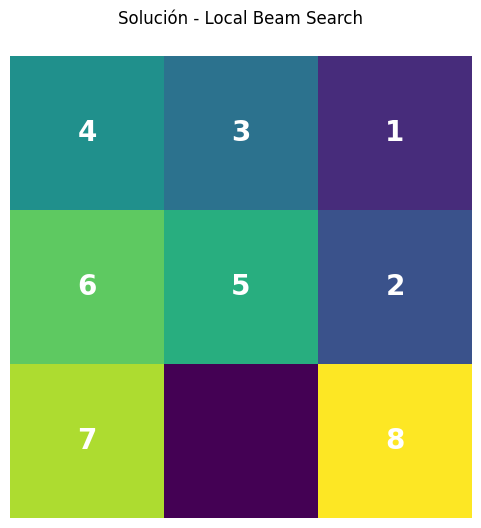

Diferencia entre casilleros: 8
¿Es estado meta? False
Tiempo de ejecución: 158.28319120407104 segundos


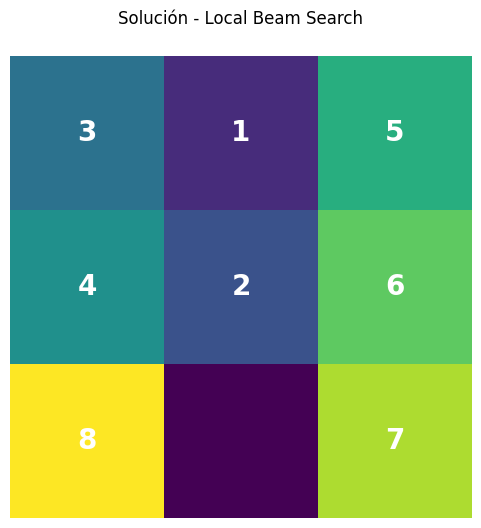

In [14]:
## TO DO Crea dos heuristicas nuevas.

# =========================
# Heurística h1: Manhattan + Linear Conflict (admisible)
# =========================
def _manhattan_excl_blank(state):
    n = state.size
    d = 0
    for r in range(n):
        for c in range(n):
            v = int(state.tiles[r, c])
            if v != 0:
                gr, gc = divmod(v - 1, n)
                d += abs(r - gr) + abs(c - gc)
    return d

def _count_inversions(seq):
    # cuenta inversiones O(k^2) (suficiente para n chico)
    inv = 0
    k = len(seq)
    for i in range(k):
        for j in range(i+1, k):
            if seq[i] > seq[j]:
                inv += 1
    return inv

def _linear_conflicts(state):
    """Cuenta conflictos lineales en filas y columnas.
    Un conflicto lineal ocurre si dos fichas están en la MISMA fila (o columna),
    ambas pertenecen a esa fila (o columna) en la meta, y su orden está invertido
    respecto del orden de columnas (o filas) objetivo. Cada par => +2 movimientos.
    """
    n = state.size
    total = 0

    # Conflictos por FILA
    for r in range(n):
        goal_cols_in_order = []
        for c in range(n):
            v = int(state.tiles[r, c])
            if v != 0:
                gr, gc = divmod(v, n)
                if gr == r:                 # la ficha pertenece a esta fila en la meta
                    goal_cols_in_order.append(gc)
        total += _count_inversions(goal_cols_in_order)

    # Conflictos por COLUMNA
    for c in range(n):
        goal_rows_in_order = []
        for r in range(n):
            v = int(state.tiles[r, c])
            if v != 0:
                gr, gc = divmod(v, n)
                if gc == c:                 # la ficha pertenece a esta columna en la meta
                    goal_rows_in_order.append(gr)
        total += _count_inversions(goal_rows_in_order)

    return total

def h1(puzzle) -> int:
    """
    h1 = Manhattan + 2 * (#conflictos lineales)
    Admisible: cada par en conflicto requiere al menos 2 movimientos extra
    además de Manhattan (AIMA, idea clásica; ver p. 119–121 sobre construcción
    de heurísticas por descomposición y relajación).
    """
    return _manhattan_excl_blank(puzzle) + 2 * _linear_conflicts(puzzle)


# =========================
# Heurística h2: Manhattan + Corner Conflict (admisible)
# =========================
def _corner_conflicts(state):
    """
    Suma +2 por cada 'conflicto de esquina':
    si una ficha de ESQUINA (distinta del 0) está en su esquina correcta y
    al menos UNA de sus fichas adyacentes requeridas (la de su borde en la misma fila
    o la del mismo borde en la misma columna) NO está en su posición objetivo,
    se agrega una penalidad de 2. Es una cota inferior válida: habrá que 'desbloquear'
    la esquina con al menos 2 movimientos.
    """
    n = state.size
    goal = np.arange(n*n).reshape(n, n)

    # esquinas y sus adyacentes "requeridas" según objetivo fila-major con 0 en (0,0)
    # esquina superior izquierda => tile 0 (es hueco, lo ignoramos)
    corners = [
        ((0, n-1), goal[0, n-1], [(0, n-2), (1, n-1)]),        # sup-der
        ((n-1, 0), goal[n-1, 0], [(n-2, 0), (n-1, 1)]),        # inf-izq
        ((n-1, n-1), goal[n-1, n-1], [(n-2, n-1), (n-1, n-2)]) # inf-der
    ]

    penalty = 0
    for (cr, cc), tile_id, adj_list in corners:
        v = int(state.tiles[cr, cc])
        if v == tile_id and v != 0:
            # si la esquina está 'ocupada' por su ficha correcta,
            # chequeamos si sus adyacentes requeridas NO están en su posición meta
            bad = 0
            for (ar, ac) in adj_list:
                if int(state.tiles[ar, ac]) != goal[ar, ac]:
                    bad += 1
            if bad >= 1:
                penalty += 2
    return penalty

def h2(puzzle) -> int:
    """
    h2 = Manhattan + Corner Conflict
    También es admisible: la penalización modela el mínimo costo adicional
    para 'liberar' una esquina correcta bloqueada por adyacentes fuera de lugar.
    """
    return _manhattan_excl_blank(puzzle) + _corner_conflicts(puzzle)


# ==============================
# Experimentos comparativos y conclusiones obtenidas:
# ==============================

start_time = time.time()
solution_sa = local_beam(initial, h1, k=8, max_iters=400_000)
sa_time = time.time() - start_time

print("Diferencia entre casilleros:", solution_sa.final_state.misplaced())
print("¿Es estado meta?", solution_sa.final_state.is_goal())
print("Tiempo de ejecución:", sa_time, "segundos")
visualize_puzzle(solution_sa.final_state, "Solución - Local Beam Search")

start_time = time.time()
solution_sa = local_beam(initial, h2, k=8, max_iters=400_000)
sa_time = time.time() - start_time

print("Diferencia entre casilleros:", solution_sa.final_state.misplaced())
print("¿Es estado meta?", solution_sa.final_state.is_goal())
print("Tiempo de ejecución:", sa_time, "segundos")
visualize_puzzle(solution_sa.final_state, "Solución - Local Beam Search")


## Ejercicio 5 - Comparativa y simulación de experimentos
Ejecuta la función de `run_comparative_analysis(epochs, experiments)` con una lista mas robusta de experimentos donde se altere los hiperparametros de las funciones.
- a) Debe cumplirse que se utilicen las 2 heuristicas nuevas definidad en el ejercicio 4.
- b) Debe existir distintas combinaciones de hiperparametros para un mismo algoritmo y heuristica. (Se espera al menos 20 experimentos)
- c) Analiza y compara los resultados argumentando cual fue el mejor en terminos de tiempo y cual fue mejor en tiempos de costos y a que se debe esto.


In [ ]:
import time
import matplotlib.pyplot as plt

def _print_table(headers, rows):
    # calcula anchos
    widths = [max(len(str(h)), *(len(str(r[i])) for r in rows)) for i, h in enumerate(headers)]
    def fmt_row(r): return " | ".join(str(v).ljust(widths[i]) for i, v in enumerate(r))
    sep = "-+-".join("-" * w for w in widths)
    print(fmt_row(headers))
    print(sep)
    for r in rows:
        print(fmt_row(r))

In [ ]:
import time
import matplotlib.pyplot as plt
import ast

def run_comparative_analysis(epochs=10, experiments=None):
    """
    Ejecuta un análisis comparativo sobre una lista de EXPERIMENTOS.
    Cada experimento es un dict con:
      - tag: str
      - algorithm: callable(initial_state, hyperparams, heuristic) -> state
      - hyperparams: dict (p. ej., {"max_iter": 400_000})
      - heuristic: callable(state) -> costo

    Requisitos:
      - NPuzzleState(PUZZLE_SIZE) para crear el estado
      - shuffle_puzzle(state, N_MOVES) para barajar
      - Cada 'algorithm' devuelve un estado con .is_goal()
    Efectos:
      - Prints mínimos por prueba
      - Grafica éxitos y costo promedio (costo medido con la heurística del experimento)
    """
    if experiments is None or not experiments:
        raise ValueError("Debes pasar una lista de 'experiments' no vacía.")

    # Estructuras de resultado
    results = {
        exp["tag"]: {"success": 0, "avg_time": 0.0, "avg_cost": 0.0, "times": [], "costs": []}
        for exp in experiments
    }

    for i in range(epochs):
        # Generar estado inicial (mismo para todos los experimentos en esta iteración)
        initial = NPuzzleState(PUZZLE_SIZE)
        initial = shuffle_puzzle(initial, N_MOVES)

        for j in range(len(experiments)):
            exp = experiments[j]
            tag = exp["tag"]

            start_time = time.time()
            sol = exp["algorithm"](initial, exp["heuristic"], exp["hyperparams"])
            elapsed = time.time() - start_time

            cost = sol.misplaced()       # costo con la heurística del experimento
            ok = sol.is_goal()

            results[tag]["times"].append(elapsed)
            results[tag]["costs"].append(cost)
            if ok:
                results[tag]["success"] += 1
            print(f"Experimento {j+1} de {len(experiments)} ejecutado con exito  [{tag}] Tiempo: {elapsed:.4f}s, Costo: {cost}, Meta: {ok}")
            

        print(f"Epoca {i+1} de {epochs} ejecutado con éxito.")

    # agregados
    for tag, r in results.items():
        r["avg_time"] = (sum(r["times"]) / epochs) if epochs else 0.0
        r["avg_cost"] = (sum(r["costs"]) / epochs) if epochs else 0.0
        # calcular mejor/peor tiempo
        r["min_time"] = min(r["times"]) if r["times"] else 0.0
        r["max_time"] = max(r["times"]) if r["times"] else 0.0

    # ===== Tabla =====
    headers = [
        "Tag",
        "Algoritmo",
        "Heurística",
        "Hyperparams (max_iter, initial_temp, cooling_rate)",
        "% de éxitos",
        "Piezas mal colocadas prom.",
        "Tiempo prom. (s)",
        "Mejor tiempo (s)",
        "Peor tiempo (s)",
    ]
    rows = []
    for exp in experiments:
        tag = exp["tag"]
        r = results[tag]

        # nombres legibles
        alg_name = getattr(exp.get("algorithm"), "__name__", "custom")
        heur_name = getattr(exp.get("heuristic"), "__name__", "custom")

        # hyperparams como str
        hp = exp.get("hyperparams", {}) or {}
        hp_str = ", ".join(f"{k}={v}" for k, v in hp.items()) if hp else "N/A"

        success_pct = (r["success"] / epochs * 100.0) if epochs else 0.0

        rows.append([
            tag,
            alg_name,
            heur_name,
            hp_str,
            f"{success_pct:.1f}%",
            f"{r['avg_cost']:.2f}",
            f"{r['avg_time']:.4f}",
            f"{r['min_time']:.4f}",
            f"{r['max_time']:.4f}",
        ])

    print("\nRESULTADOS (Tabla)")
    _print_table(headers, rows)

    # ===== Gráficos =====
    tags = [exp["tag"] for exp in experiments]

    # 1) Tasa de éxito (%)
    success_rates = [(results[tag]["success"] / epochs)  for tag in tags]
    plt.figure(figsize=(max(10, len(experiments)), 4.8))
    plt.bar(tags, success_rates)
    plt.axhline(y=1, color="red", linestyle="--", label="Siempre da un resultado")
    plt.title("Tasa de éxito por experimento (%)")
    plt.xlabel("Experimento (Tag)")
    plt.ylabel("Éxito (%)")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()

    # 2) Piezas mal colocadas (promedio)
    avg_costs = [results[tag]["avg_cost"] for tag in tags]
    min_costs = [min(results[tag]["costs"]) if results[tag]["costs"] else 0 for tag in tags]
    max_costs = [max(results[tag]["costs"]) if results[tag]["costs"] else 0 for tag in tags]

    plt.figure(figsize=(max(10, len(experiments)), 5.2))
    plt.plot(tags, min_costs, marker="o", linestyle="--", label="Mejor Caso")
    plt.plot(tags, avg_costs, marker="o", linestyle="-", label="Caso Estandar")
    plt.plot(tags, max_costs, marker="o", linestyle=":", label="Peor caso")

    # Línea horizontal roja en y=9
    plt.axhline(y=9, color="red", linestyle="--", label="Peor caso y=9")

    plt.title("Piezas mal colocadas por experimento")
    plt.xlabel("Experimento (Tag)")
    plt.ylabel("Piezas mal colocadas")
    plt.xticks(rotation=20, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

      # 3) Tiempos: promedio, mejor (min), peor (max) — gráfico de líneas
    avg_times = [results[tag]["avg_time"] for tag in tags]
    min_times = [results[tag]["min_time"] for tag in tags]
    max_times = [results[tag]["max_time"] for tag in tags]

    plt.figure(figsize=(max(10, len(experiments)), 5.2))
    plt.plot(tags, min_times, marker="o", label="Mejor (min)")
    plt.plot(tags, avg_times, marker="o", label="Promedio")
    plt.plot(tags, max_times, marker="o", label="Peor (max)")
    plt.title("Tiempos por experimento (s)")
    plt.xlabel("Experimento (Tag)")
    plt.ylabel("Segundos")
    plt.xticks(rotation=20, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
MAX_ITERATIONS_SIZE = 400_000
experiments = [

    # Hill Climbing
    {"tag": "HC #1", "algorithm": hill_climbing, "hyperparams": {"max_iter": MAX_ITERATIONS_SIZE}, "heuristic": manhattan_distance},
    {"tag": "HC #2", "algorithm": hill_climbing, "hyperparams": {"max_iter": MAX_ITERATIONS_SIZE}, "heuristic": euclidean_distance},
    # Simulated Annealing
    {"tag": "SA #1", "algorithm": simulated_annealing, "hyperparams": {"max_iter": MAX_ITERATIONS_SIZE, "initial_temp":35, "cooling_rate":0.9997 }, "heuristic": manhattan_distance},
    {"tag": "SA #2", "algorithm": simulated_annealing, "hyperparams":  {"max_iter": MAX_ITERATIONS_SIZE, "initial_temp":35, "cooling_rate":0.9997 }, "heuristic": euclidean_distance},

    # Local Beam
    {"tag": "Beam #1", "algorithm": local_beam,
     "hyperparams": {"beam_size": 10, "max_iter": max(100_000, MAX_ITERATIONS_SIZE), "walk_steps": 25},
     "heuristic": manhattan_distance},
    {"tag": "Beam #2", "algorithm": local_beam,
     "hyperparams": {"beam_size": 10, "max_iter": max(100_000, MAX_ITERATIONS_SIZE), "walk_steps": 25},
     "heuristic": euclidean_distance},

    ]

results = run_comparative_analysis(epochs=10, experiments=experiments)

TypeError: '<' not supported between instances of 'int' and 'dict'

Espacio para comentarios ejercicio 5
